<a href="https://colab.research.google.com/github/majavk/Data_Science_Portfolio/blob/main/classification_wine_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fraud Wine detection

Based on a chemical properties of wines the wine should be cathegorized as a "Legit" or "Fraud".


Data Source: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Objective of this project is to get the best predictions.

In [ ]:
from collections import Counter

import imblearn
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Udemy_ML/DATA/'
df = pd.read_csv(path+"wine_fraud.csv")

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


In [ ]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

In [ ]:
df['quality'].value_counts(normalize=True)

Legit    0.962136
Fraud    0.037864
Name: quality, dtype: float64

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


#Exploratory Data Analysis

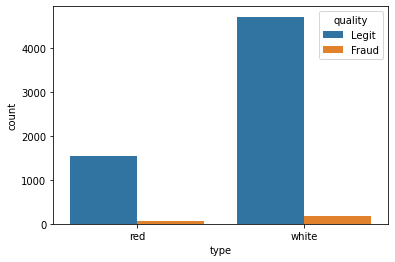

In [ ]:
sns.countplot(x='type',hue='quality',data=df)

In [ ]:
reds = df[df["type"]=='red']

In [ ]:
whites = df[df["type"]=='white']

In [ ]:
print("Percentage of fraud in Red Wines:")
print(100* (len(reds[reds['quality']=='Fraud'])/len(reds)))

Percentage of fraud in Red Wines:
3.9399624765478425


In [ ]:
print("Percentage of fraud in White Wines:")
print(100* (len(whites[whites['quality']=='Fraud'])/len(whites)))

Percentage of fraud in White Wines:
3.7362188648427925


In [ ]:
df['Fraud']= df['quality'].map({'Legit':0,'Fraud':1})

In [ ]:
df.corr()['Fraud']

fixed acidity           0.021794
volatile acidity        0.151228
citric acid            -0.061789
residual sugar         -0.048756
chlorides               0.034499
free sulfur dioxide    -0.085204
total sulfur dioxide   -0.035252
density                 0.016351
pH                      0.020107
sulphates              -0.034046
alcohol                -0.051141
Fraud                   1.000000
Name: Fraud, dtype: float64

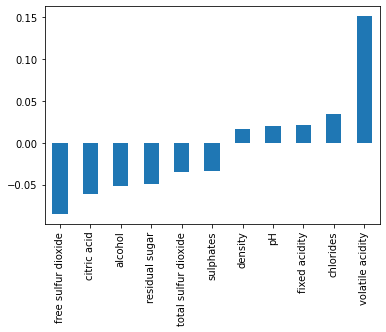

In [ ]:
df.corr()['Fraud'][:-1].sort_values().plot(kind='bar')

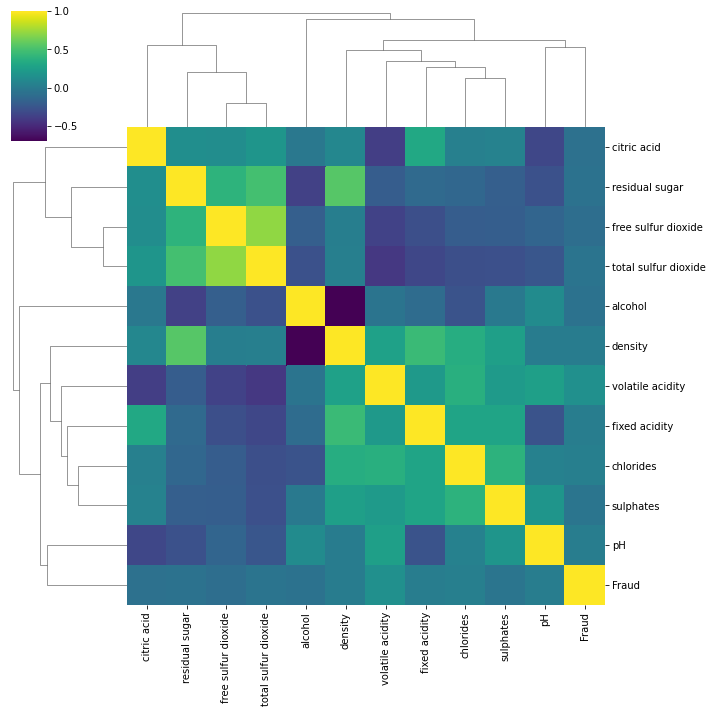

In [ ]:
sns.clustermap(df.corr(),cmap='viridis')

#Machine Learning

In [ ]:
rs = 123
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

In [ ]:
def split_data(df):
    X = df.loc[ : , df.columns != 'Fraud']
    y = df['Fraud'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

## SVM

In [ ]:
df['type'] = pd.get_dummies(df['type'],drop_first=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,0


In [ ]:
df = df.drop('Fraud',axis=1)

In [ ]:
X = df.drop('quality',axis=1)
y = df['quality']

In [ ]:
X_train, X_test, y_train, y_test = split_data(df)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(class_weight='balanced')

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C':[0.001,0.01,0.1,0.5,1],'gamma':['scale','auto']}
grid = GridSearchCV(svc,param_grid)

In [ ]:
grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [ ]:
grid.best_params_

{'C': 1, 'gamma': 'auto'}

##SVM-Model Evaluation


In [ ]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report

In [ ]:
grid_pred = grid.predict(scaled_X_test)

In [ ]:
confusion_matrix(y_test,grid_pred)

array([[ 17,  10],
       [ 92, 531]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


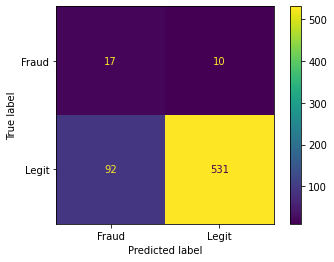

In [ ]:
plot_confusion_matrix(grid,scaled_X_test,y_test)

In [ ]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

       Fraud       0.16      0.63      0.25        27
       Legit       0.98      0.85      0.91       623

    accuracy                           0.84       650
   macro avg       0.57      0.74      0.58       650
weighted avg       0.95      0.84      0.88       650



## Bagging Classifier

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1,stratify=y)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None, class_weight='balanced')
bag = BaggingClassifier(base_estimator=tree,n_estimators=500,max_samples=1.0,max_features=1.0,bootstrap=True,bootstrap_features=False,n_jobs=1,random_state=1)

##Bagging Classifier-Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'% (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.947


In [ ]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'% (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.965


In [ ]:
confusion_matrix(y_test,y_test_pred)

array([[   3,   46],
       [   0, 1251]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


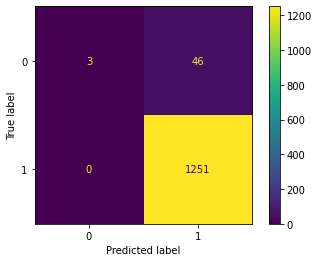

In [ ]:
plot_confusion_matrix(bag,X_test,y_test)

In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.06      0.12        49
           1       0.96      1.00      0.98      1251

    accuracy                           0.96      1300
   macro avg       0.98      0.53      0.55      1300
weighted avg       0.97      0.96      0.95      1300



##AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1,max_depth=1,class_weight='balanced')
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'% (tree_train, tree_test))


Decision tree train/test accuracies 0.719/0.738


##AdaBoost-Model Evaluation

In [ ]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'% (ada_train, ada_test))


AdaBoost train/test accuracies 0.833/0.839


In [ ]:
confusion_matrix(y_test,y_test_pred)

array([[  31,   18],
       [ 191, 1060]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


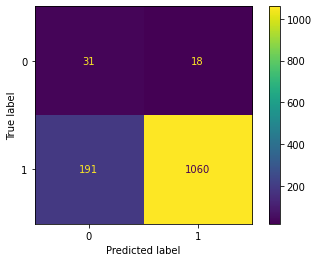

In [ ]:
plot_confusion_matrix(ada,X_test,y_test)

In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.14      0.63      0.23        49
           1       0.98      0.85      0.91      1251

    accuracy                           0.84      1300
   macro avg       0.56      0.74      0.57      1300
weighted avg       0.95      0.84      0.88      1300



#Conclusion

The Bagging classifier gives very small recall, while the AdaBoost gives low precision and recall.

The best results are with SVM model. For 92 legitimate wines the model predicted fraudulent, and for 10 fraudulent wines the model predicted legitimate.

Because of the imbalanced data set the precision and recall will tell us how good our model is. According to the report the precision for fraudulent wine prediction is only 0.16 and recall 0.63. 

This model should be improved by balancing the imbalanced dataset.